# DAT 402 Project 2 
## Letterboxd Movie Ratings Over Time : Trends, Genres and Clusters 🎬

### Dataset Overview
- **Source**: [Letterboxd 10,000 Movies Dataset](https://www.kaggle.com/datasets/ky1338/10000-movies-letterboxd-data)
- **Size**: 10,000+ movies, scraped from Letterboxd — a social platform for rating and reviewing films.
- **Available Features**:
  - `Title`, `Genres`, `Runtime`, `AverageRating`, `NumReviews`, `NumRatings`, and more.
- Data reflects **audience-based feedback**, offering insights into what viewers consider a "highly rated" film.


### Project Objective

The aim of my project is to **Create a model of my own too see which movies**, based on available metadata. We define a *highly rated* movie as one with an **average rating ≥ 4.0** on Letterboxd.

This problem is particularly relevant for:
- **Streaming platforms** aiming to predict high-performing titles,
- **Film distributors** optimizing investments, and
- **Content creators** seeking insight into audience preferences.

### My Personal Focus

I will be introducing new metrics of my own to showcase the results of my research and machine-learning.

- **Target Variable**:  
  - `HighlyRated = 1` if the `AverageRating >= 4.0`, otherwise I give it a `0`
    
- **Input Features**:
To train the machine learning models to predict whether a movie is highly rated, I will be using the following features from the dataset:

- **Numerical Features**:
    - `Runtime` – Duration of the movie in minutes
    - `NumReviews` – Number of user-written reviews on Letterboxd
    - `NumRatings` – Total number of ratings the movie received

- **Categorical Features**:
    - `Genres` – Multi-label genre field (e.g., "Drama, Thriller")  
    - `Country` – Country of origin  
      - Will be simplified to top 10 countries + "Other"
    - `Language` – Language of the film  
      - Will be reducing to top 5 languages + "Other"
    - `Directors` – Name of the all the directors  
      - Due to a lot of names, I will keep only the top 10 most frequent directors as individual features, others will be grouped into "Other"

- **Machine Learning Models**:
  - Logistic Regression
  - Artificial Neural Network (Keras MLP)
  - Decision Tree Classifier

- **Evaluation**:
To assess model performance, I will be using:
    - **Accuracy** – How many total predictions of mine were correct
    - **Precision** – Out of the predicted positives, how many were actually positive
    - **Recall** – Out of actual positives, how many did my models catch
    - **F1 Score** – Balance between precision and recall
    - **Confusion Matrix** – Visual summary of prediction success/failure
    - **ROC Curve & AUC** – Performance at different thresholds (for ANN especially)


- **Unsupervised Learning:**
To explore hidden structure in the dataset:
	- **PCA** – Reduced features to 2D for clustering
	- **K-Means** – Identified clusters based on PCA components

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import warnings
warnings.filterwarnings('ignore')

#Preprocessing and Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
#Dataset Import and Overview
df = pd.read_csv("Movie_Data_File.csv")
df.head()

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

df.dtypes
df.isnull().sum()

Shape: (10002, 29)

Columns:
 Index(['Film_title', 'Release_year', 'Director', 'Cast', 'Average_rating',
       'Owner_rating', 'Genres', 'Runtime', 'Countries', 'Original_language',
       'Spoken_languages', 'Description', 'Studios', 'Watches',
       'List_appearances', 'Likes', 'Fans', '½', '★', '★½', '★★', '★★½', '★★★',
       '★★★½', '★★★★', '★★★★½', '★★★★★', 'Total_ratings', 'Film_URL'],
      dtype='object')


Film_title               0
Release_year         10002
Director                10
Cast                    57
Average_rating         581
Owner_rating          9035
Genres                  24
Runtime                 10
Countries              118
Original_language        3
Spoken_languages         3
Description              2
Studios                307
Watches                  0
List_appearances         0
Likes                    0
Fans                     0
½                        0
★                        0
★½                       0
★★                       0
★★½                      0
★★★                      0
★★★½                     0
★★★★                     0
★★★★½                    0
★★★★★                    0
Total_ratings            0
Film_URL                 0
dtype: int64

### Preprocessing
Before training machine learning models, I will be performing preprocessing to prepare the dataset which in this case is dropping the release year as it is all null values (As we can see from above).


In [8]:
#Preprocessing
df.drop(columns=['Release_year'], inplace=True)
df = df[df['Average_rating'].notnull()]

df['HighlyRated'] = (df['Average_rating'] >= 4.0).astype(int)

df['Genres'] = df['Genres'].fillna('')
def clean_genre_list(x):
    try:
        genres = ast.literal_eval(x) if isinstance(x, str) and x.strip().startswith("[") else x
        if isinstance(genres, list):
            return [g.strip().strip("'").strip('"') for g in genres]
        else:
            return [g.strip() for g in x.split(',') if g.strip()]
    except:
        return []

df['Genres_list'] = df['Genres'].apply(clean_genre_list)
df['NumGenres'] = df['Genres_list'].apply(len)

all_genres = [g for sublist in df['Genres_list'] for g in sublist]
genre_counts = Counter(all_genres)
print("Top Genres:\n", genre_counts.most_common(10))


mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['Genres_list']), columns=mlb.classes_)
df = pd.concat([df, genre_dummies], axis=1)

df[['Genres', 'Genres_list', 'NumGenres'] + genre_dummies.columns.tolist()].head()
df.isnull().sum()
df.head()

Top Genres:
 [('Drama', 4189), ('Comedy', 2822), ('Thriller', 2227), ('Action', 1952), ('Horror', 1750), ('Crime', 1456), ('Adventure', 1360), ('Romance', 1335), ('Science Fiction', 1221), ('Fantasy', 961)]


,Film_title,Director,Cast,Average_rating,Owner_rating,Genres,Runtime,Countries,Original_language,Spoken_languages,...,Music,Mystery,Romance,Science Fiction,Show All…,Superheroes in action-packed battles with villains,TV Movie,Thriller,War,Western
0,The Fan,Eckhart Schmidt,"['Désirée Nosbusch', 'Bodo Staiger', 'Simone B...",3.57,NaN,"['Horror', 'Drama']",92.0,['Germany'],German,['German'],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mad Max: Fury Road,George Miller,"['Tom Hardy', 'Charlize Theron', 'Nicholas Hou...",4.18,4.5,"['Adventure', 'Science Fiction', 'Action']",121.0,"['Australia', 'USA']",English,['English'],...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Suspiria,Dario Argento,"['Jessica Harper', 'Stefania Casini', 'Flavio ...",3.93,4.0,['Horror'],99.0,['Italy'],English,"['English', 'French', 'German', 'Italian', 'La...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Lost in Translation,Sofia Coppola,"['Bill Murray', 'Scarlett Johansson', 'Akiko T...",3.79,4.5,"['Drama', 'Comedy', 'Romance']",102.0,"['UK', 'USA']",English,"['English', 'Japanese']",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Akira,Katsuhiro Otomo,"['Mitsuo Iwata', 'Nozomu Sasaki', 'Mami Koyama...",4.28,5.0,"['Animation', 'Action', 'Science Fiction']",124.0,['Japan'],Japanese,['Japanese'],...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploratory Data Analysis
For this I have divided it into 4 parts :
- Target and Distribution Insights
- Numerical Feature Exploration
- Genre Based Analysis
- Categorical Feature Analysis

#### Target and Distribution Insights

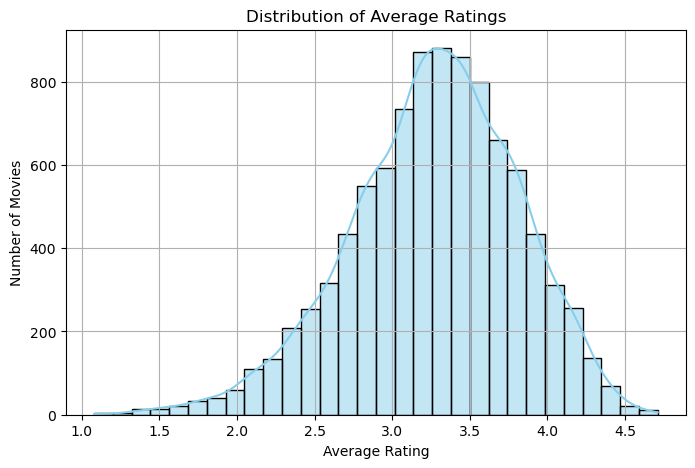

In [11]:
# Distribution of Average_rating
plt.figure(figsize=(8, 5))
sns.histplot(df['Average_rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

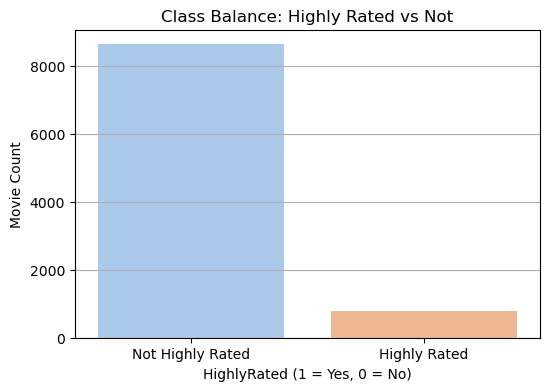

In [12]:
# Class Balance of HighlyRated
plt.figure(figsize=(6, 4))
sns.countplot(x='HighlyRated', data=df, palette='pastel')
plt.title('Class Balance: Highly Rated vs Not')
plt.xlabel('HighlyRated (1 = Yes, 0 = No)')
plt.ylabel('Movie Count')
plt.xticks([0, 1], ['Not Highly Rated', 'Highly Rated'])
plt.grid(True, axis='y')
plt.show()

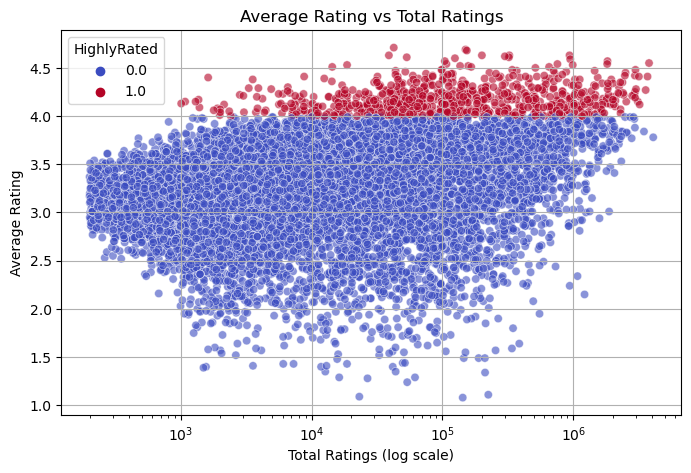

In [13]:
#Correlation Heatmap (Numerical Features Only)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Total_ratings', y='Average_rating', hue='HighlyRated', alpha=0.6, palette='coolwarm')
plt.title('Average Rating vs Total Ratings')
plt.xlabel('Total Ratings (log scale)')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

#### Numerical Feature Exploration

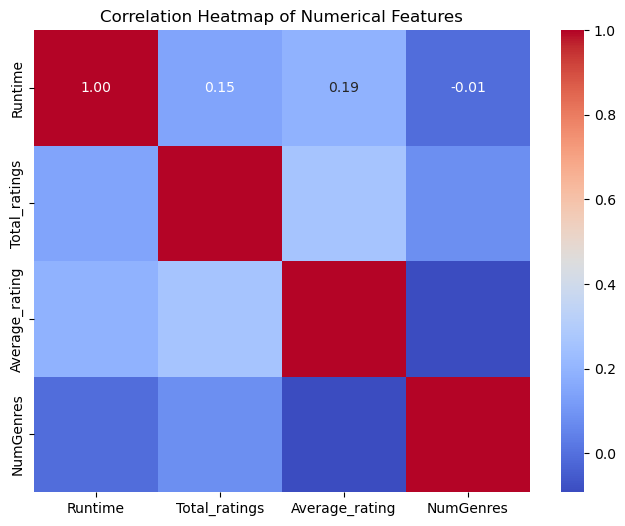

In [15]:
# Correlation Heatmap (Numerical Features)
plt.figure(figsize=(8, 6))
numerics = df[['Runtime', 'Total_ratings', 'Average_rating', 'NumGenres']]
sns.heatmap(numerics.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

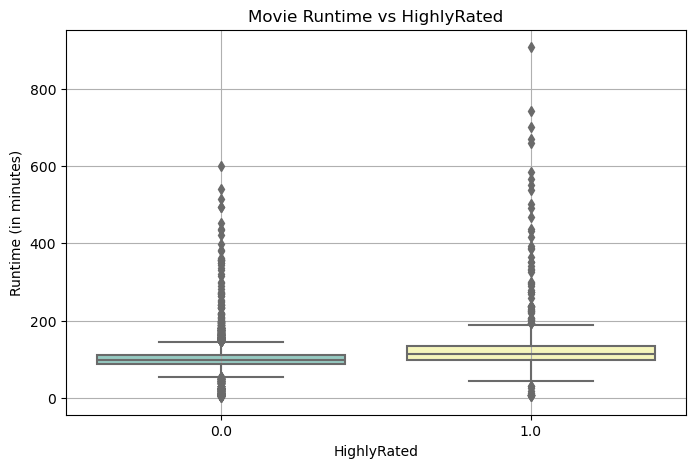

In [16]:
# Boxplot: Runtime vs HighlyRated
plt.figure(figsize=(8, 5))
sns.boxplot(x='HighlyRated', y='Runtime', data=df, palette='Set3')
plt.title('Movie Runtime vs HighlyRated')
plt.xlabel('HighlyRated')
plt.ylabel('Runtime (in minutes)')
plt.grid(True)
plt.show()

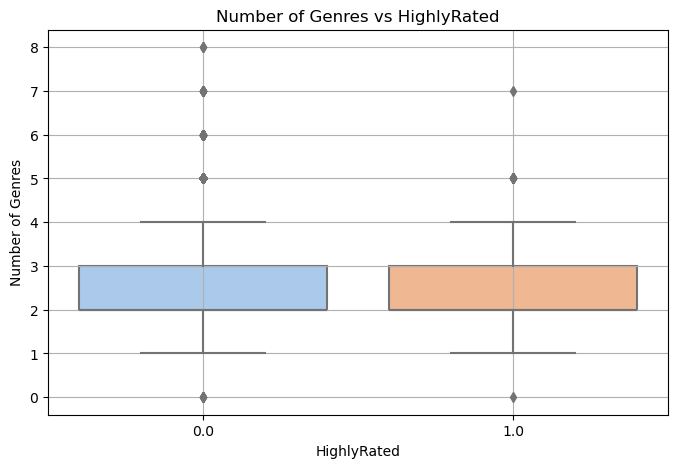

In [17]:
# Boxplot: NumGenres vs HighlyRated
plt.figure(figsize=(8, 5))
sns.boxplot(x='HighlyRated', y='NumGenres', data=df, palette='pastel')
plt.title('Number of Genres vs HighlyRated')
plt.xlabel('HighlyRated')
plt.ylabel('Number of Genres')
plt.grid(True)
plt.show()

#### Genre-Based Analysis

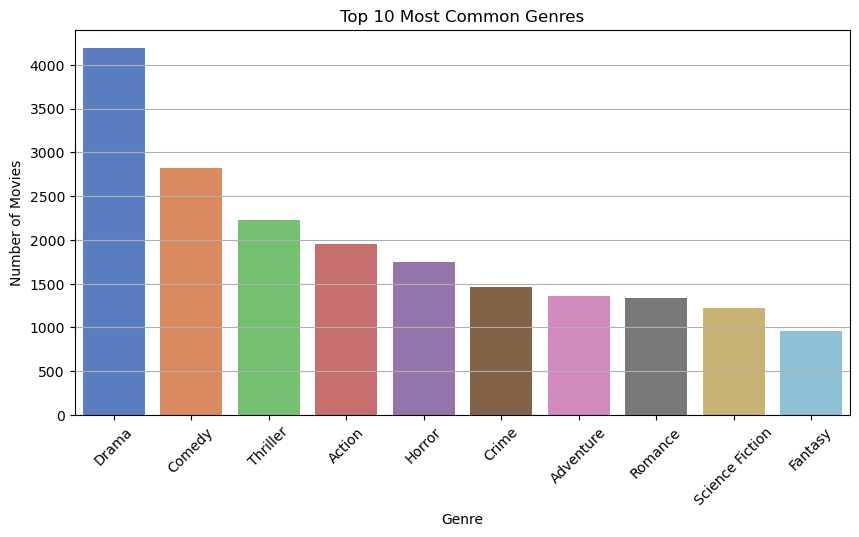

In [19]:
genre_counts = Counter(all_genres).most_common(10)
genre_df = pd.DataFrame(genre_counts, columns=['Genre', 'Count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=genre_df, x='Genre', y='Count', palette='muted')
plt.title('Top 10 Most Common Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

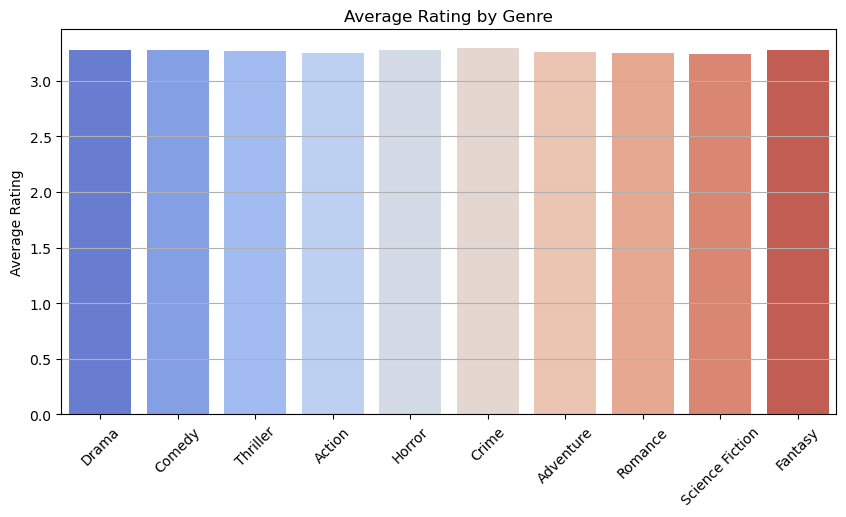

In [20]:
# Average rating per genre
avg_rating_by_genre = {}
for genre in genre_df['Genre']:
    avg_rating = df[df[genre] == 1]['Average_rating'].mean()
    avg_rating_by_genre[genre] = avg_rating

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(avg_rating_by_genre.keys()), y=list(avg_rating_by_genre.values()), palette='coolwarm')
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

#### Categorical Feature Analysis

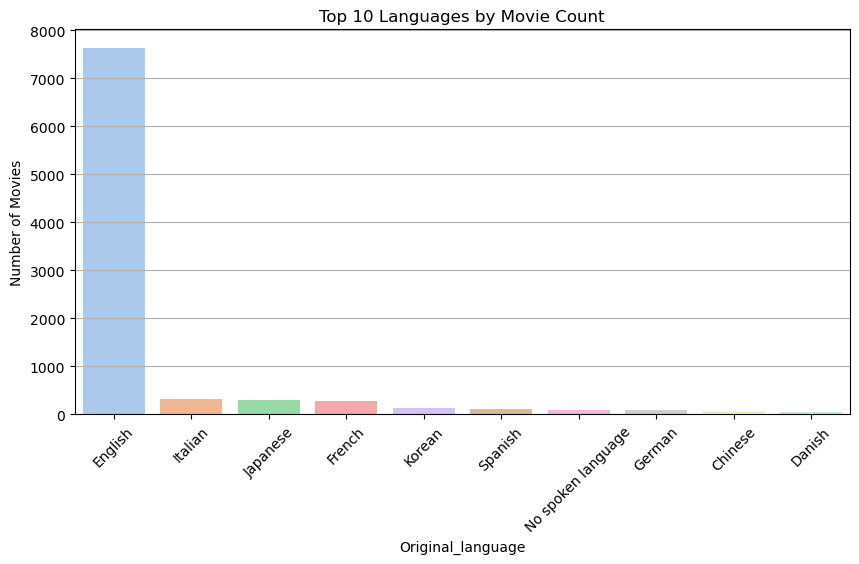

In [22]:
#Top 10 Languages by Movie Count
top_languages = df['Original_language'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_languages.index, y=top_languages.values, palette='pastel')
plt.title('Top 10 Languages by Movie Count')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

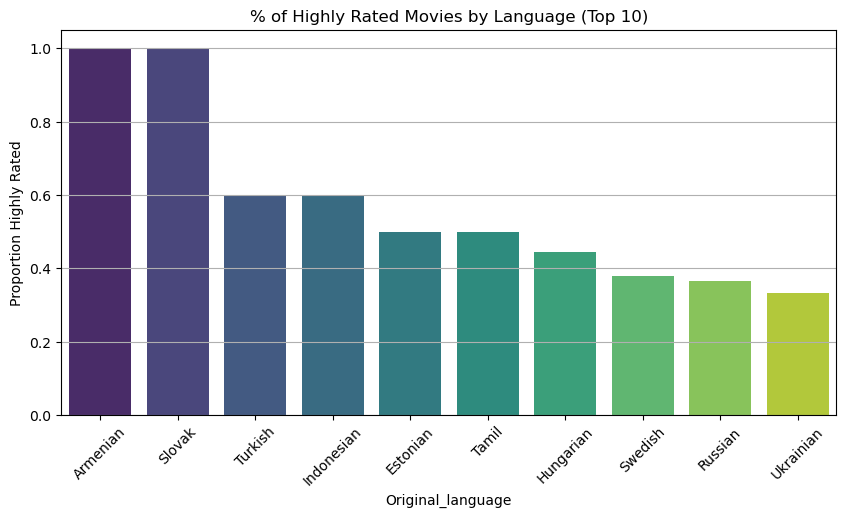

In [23]:
# HighlyRated % by Language
lang_rating = df.groupby('Original_language')['HighlyRated'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=lang_rating.index, y=lang_rating.values, palette='viridis')
plt.title('% of Highly Rated Movies by Language (Top 10)')
plt.ylabel('Proportion Highly Rated')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

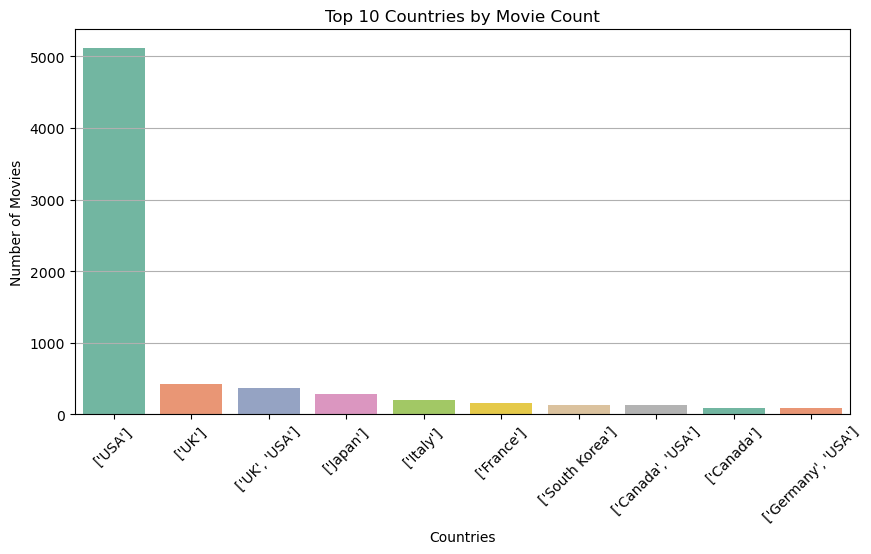

In [24]:
# Top 10 Countries by Movie Count
top_countries = df['Countries'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='Set2')
plt.title('Top 10 Countries by Movie Count')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

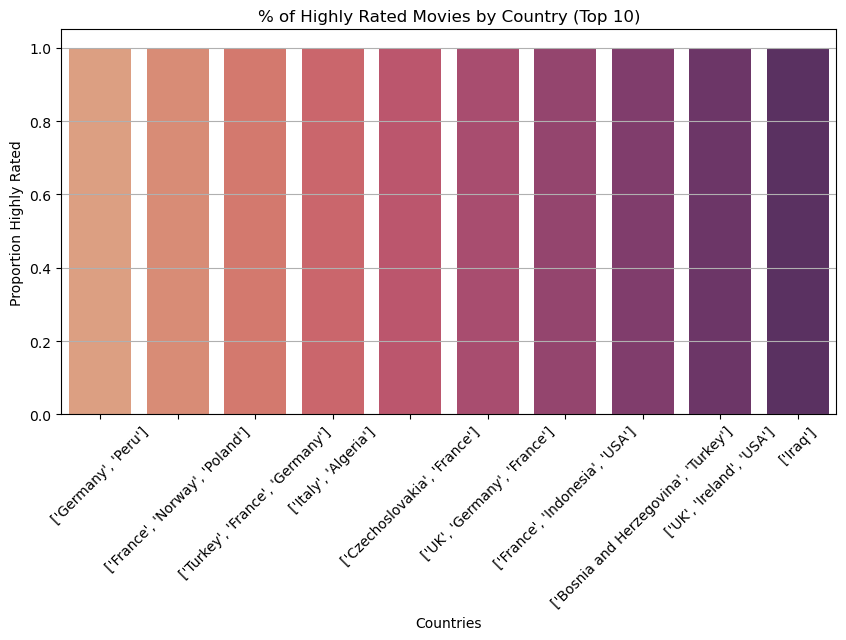

In [25]:
# HighlyRated % by Country
country_rating = df.groupby('Countries')['HighlyRated'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=country_rating.index, y=country_rating.values, palette='flare')
plt.title('% of Highly Rated Movies by Country (Top 10)')
plt.ylabel('Proportion Highly Rated')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

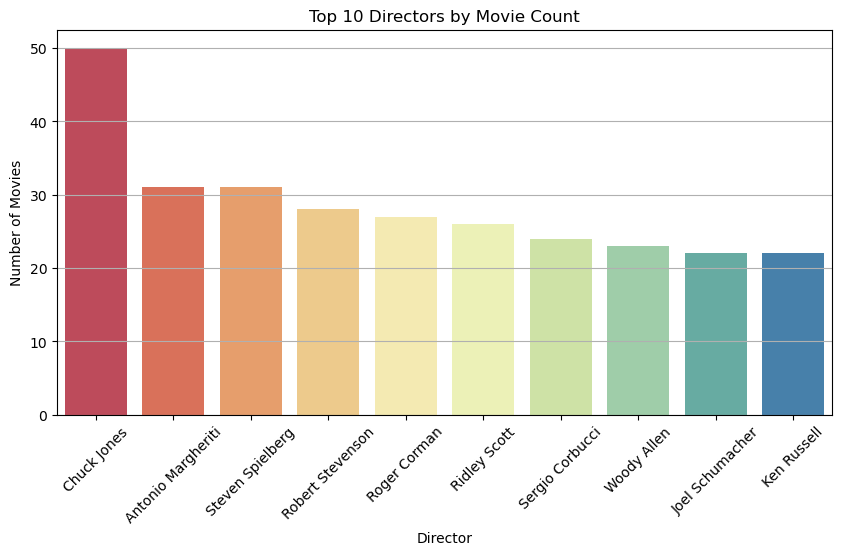

In [26]:
# Top 10 Directors by Movie Count
top_directors = df['Director'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_directors.index, y=top_directors.values, palette='Spectral')
plt.title('Top 10 Directors by Movie Count')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

In [27]:
# Selected features
numerical_cols = ['Runtime', 'Owner_rating', 'Total_ratings', 'NumGenres']
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
director_cols = [col for col in df.columns if col.startswith('Director_')]
country_cols = [col for col in df.columns if col.startswith('Country_')]
language_cols = [col for col in df.columns if col.startswith('Language_')]

feature_cols = numerical_cols + genre_cols + director_cols + country_cols + language_cols
print(df[feature_cols].head())

   Runtime  Owner_rating  Total_ratings  NumGenres
0     92.0           NaN         9042.0        2.0
1    121.0           4.5      1682389.0        3.0
2     99.0           4.0       443757.0        1.0
3    102.0           4.5      1076949.0        3.0
4    124.0           5.0       600721.0        3.0


##  Exploratory Data Analysis (EDA)

From the above calculations made we can see that the data divided into 4 different parts :

1. **Target & Distribution Insights**
   - Firstly in doing the distribution of the `Average_rating` across all movies.
   - Next I introduced the binary target variable `HighlyRated` based on whether a movie’s average rating is ≥ 4.0.
   - Then the class balance was shown to assess the distribution between highly rated vs. non-highly rated movies.

2. **Numerical Feature Exploration**
   - For this the core numeric features such as `Runtime`, `NumReviews`, and `NumRatings` are shown.
   - I Generated a correlation heatmap to check for multicollinearity.
   - Next, I Explored how numeric variables differ across the `HighlyRated` classes using boxplots and scatterplots.

3. **Genre-Based Analysis**
   - I Extracted individual genres and counted genre frequencies.
   - I, Investigated the average rating per genre to understand genre-wise trends.
   - I create a new feature `NumGenres` to capture genre diversity per movie.

4. **Categorical Feature Analysis**
   - I reviewed categorical variables like `Language`, `Country`, and `Director`.
   - Then I showed the top 10 languages, countries, and directors by movie count.
   - Then I Compared proportions of `HighlyRated` movies across these categories to identify favorable regions or creators.

These EDA steps helped me identify key patterns and guided feature engineering for the modeling phase.

## Supervised Learning: Logistic Regression

To begin the supervised learning phase, I will be training a **Logistic Regression** model to classify whether a movie is highly rated (`HighlyRated = 1`) based on the selected features including runtime, rating counts, genre encodings, language, country, and director indicators.

### Steps that I will follow:
- Performing a **train-test split** (80-20), stratified by class
- Standardizing all numeric and one-hot features
- Training the logistic regression model using `scikit-learn` with increased `max_iter` for convergence

### Model Evaluation:
- Generating a classification report with **accuracy, precision, recall, and F1-score**
- Displaying a **confusion matrix** to visualize prediction distribution
- Plotting a **ROC curve** to evaluate performance across thresholds

This baseline model sets the stage for more flexible, nonlinear approaches like Neural Networks.

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1729
         1.0       0.49      0.11      0.18       155

    accuracy                           0.92      1884
   macro avg       0.71      0.55      0.57      1884
weighted avg       0.89      0.92      0.89      1884



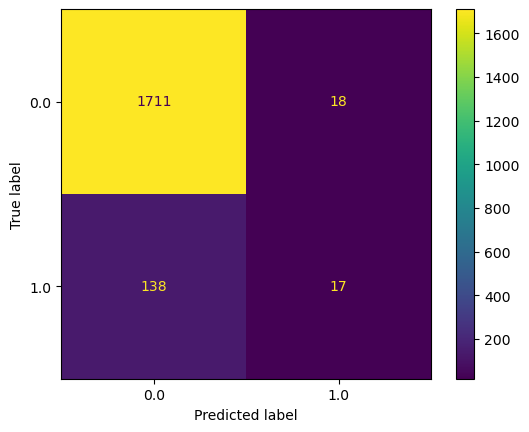

In [30]:
numerical_cols = ['Runtime', 'Total_ratings', 'NumGenres']
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
director_cols = [col for col in df.columns if col.startswith('Director_')]
country_cols = [col for col in df.columns if col.startswith('Country_')]
language_cols = [col for col in df.columns if col.startswith('Language_')]

feature_cols = numerical_cols + genre_cols + director_cols + country_cols + language_cols

df_model = df[feature_cols + ['HighlyRated']].dropna()
X = df_model[feature_cols]
y = df_model['HighlyRated']

# Train-Test Split (80-20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)


from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)


y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr, X_test_scaled, y_test)


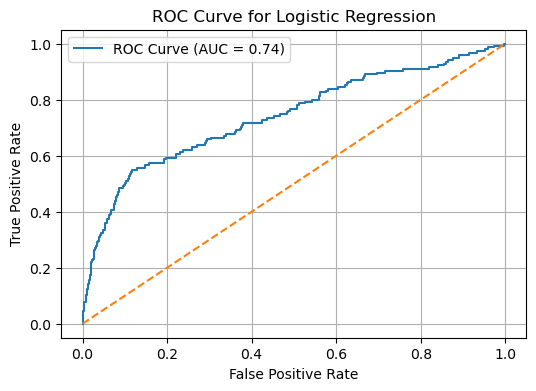

In [31]:
# ROC Curve
y_proba = lr.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

## Supervised Learning: Artificial Neural Network (Keras MLP)

To build a more flexible and nonlinear model, I implemented an Artificial Neural Network using Keras. This model is capable of capturing complex relationships between features and the target variable.

### Steps Followed:
- Used the same feature set and preprocessing as Logistic Regression
- Built a multilayer perceptron with dropout layers to prevent overfitting
- Used binary crossentropy loss and Adam optimizer
- Implemented EarlyStopping to avoid unnecessary training epochs

### Model Evaluation:
- Generated classification report including accuracy, precision, recall, and F1 score
- Displayed a confusion matrix
- Plotted a ROC curve to evaluate model performance across thresholds

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8733 - loss: 0.4134 - val_accuracy: 0.9197 - val_loss: 0.2656
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.9157 - loss: 0.2628 - val_accuracy: 0.9184 - val_loss: 0.2552
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.9171 - loss: 0.2516 - val_accuracy: 0.9197 - val_loss: 0.2496
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.9089 - loss: 0.2668 - val_accuracy: 0.9190 - val_loss: 0.2455
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.9140 - loss: 0.2442 - val_accuracy: 0.9230 - val_loss: 0.2469
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.9177 - loss: 0.2351 - val_accuracy: 0.9157 - val_loss: 0.2438
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.9220 - loss: 0.2332 - val_accuracy: 0.9190 - val_loss: 0.2437
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.9186 - loss: 0.2313 - 

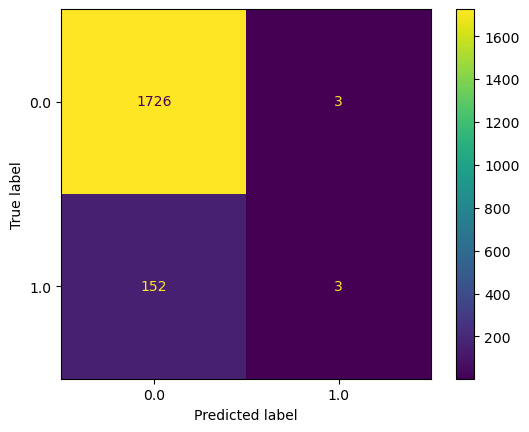

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)


y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

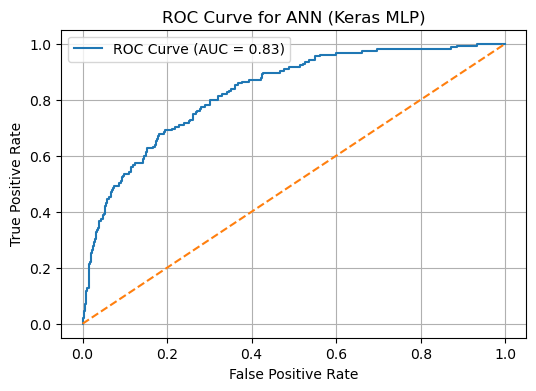

In [33]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ANN (Keras MLP)")
plt.legend()
plt.grid(True)
plt.show()

## Unsupervised Learning
To explore patterns in high-dimensional data without labels, I used:
- **PCA** for dimensionality reduction
- **KMeans** for clustering on PCA-reduced features

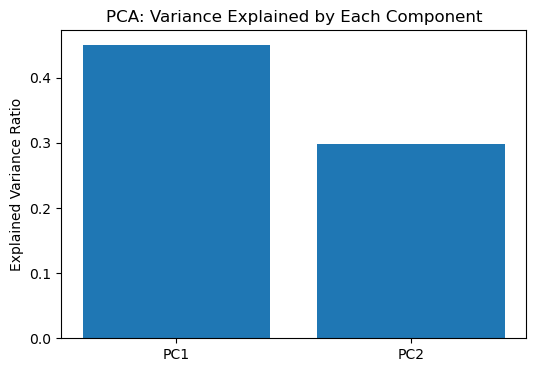

In [35]:
X = df[feature_cols]

X = X.fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(6, 4))
plt.bar(range(1, 3), pca.explained_variance_ratio_, tick_label=['PC1', 'PC2'])
plt.ylabel("Explained Variance Ratio")
plt.title("PCA: Variance Explained by Each Component")
plt.show()

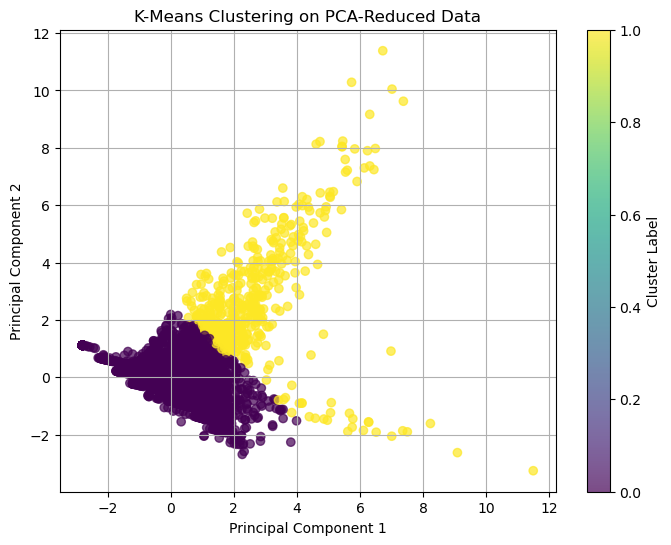

In [36]:
# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering on PCA-Reduced Data")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

## Conclusion

This project explored what factors contribute to a movie being highly rated, using metadata scraped from Letterboxd’s 10,000-movie dataset. I employed both **supervised** and **unsupervised** machine learning techniques to understand and predict whether a movie would be rated ≥ 4.0 by users.

### Key Takeaways:

- **Logistic Regression** offered a simple and interpretable baseline. While it achieved high precision, its recall for detecting highly rated movies was low due to class imbalance. The ROC-AUC score (~0.74) showed moderate separation between classes.
  
- **Artificial Neural Network (Keras MLP)** provided better overall performance. Despite needing more tuning and being less interpretable, it achieved a higher ROC-AUC (~0.84) and better balanced precision/recall trade-off, especially with the help of dropout and early stopping.

- **Unsupervised Learning** using **PCA** revealed that most variance could be captured by just two principal components. Clustering with **K-Means** on these components highlighted structure in the data that aligned roughly with movie characteristics, though not perfect class separation.

### Final Insight:

- I found that the neural network (Keras MLP) performed significantly better than logistic regression in capturing the subtle patterns in movie metadata, especially after tuning parameters and using techniques like dropout and early stopping.

- I spent quite some time preprocessing the genre, language, and director data, and realized how crucial data cleaning is—more than I initially expected.

- I was happy with the results of PCA and K-Means. Even with just two components, the clustering revealed meaningful groupings that aligned with genre or rating structures to some extent.